In [21]:
# prior_field_maps.py
import os, sys, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Prefer your consolidated utils if present; fallback to the benchmark module
def _import_utils():
    try:
        import test_gpt as utils
        return utils, "test_gpt"
    except Exception:
        import benchmark_agnp_priors_llm as utils
        return utils, "benchmark_agnp_priors_llm"
    
def load_oracle(p):
    """
    Load oracle.pkl produced by agnp_build_oracle.py and expose a .predict(DataFrame)->np.ndarray API.
    """
    # Prefer our AgNPOracle wrapper to ensure consistent behavior
    from agnp_oracle import AgNPOracle
    import numpy as np, pandas as pd
    class _OracleAdapter:
        def __init__(self, path):
            self._o = AgNPOracle(path)
            self.features = self._o.features
        def predict(self, X_df: "pd.DataFrame"):
            xs = X_df[self.features].to_dict(orient="records")
            y = self._o.evaluate_batch(xs)
            return np.array(y, dtype=float)
    return _OracleAdapter(p)


oracle__ = load_oracle("agnp_oracle_out/oracle.pkl")

def _mid_dict(schema):
    return {v.name: 0.5*(float(v.low)+float(v.high)) for v in schema.continuous}

def _grid2d(schema, var_x, var_y, n=120, fixed=None):
    if fixed is None: fixed = {}
    vx = next(v for v in schema.continuous if v.name == var_x)
    vy = next(v for v in schema.continuous if v.name == var_y)
    xs = np.linspace(vx.low, vx.high, n)
    ys = np.linspace(vy.low, vy.high, n)
    base = _mid_dict(schema)
    base.update({k: float(v) for k,v in (fixed or {}).items()})
    rows = []
    for y in ys:
        for x in xs:
            r = dict(base)
            r[var_x] = float(x); r[var_y] = float(y)
            rows.append(r)
    return pd.DataFrame(rows), xs, ys


def _to_np(x):
    return x.values if hasattr(x, "values") else np.asarray(x)


def _plot_field(prior_name, prior_dict, schema, var_x, var_y, n, fixed, out_dir, vmin=None, vmax=None, show=False, oracle=None):
    try:
        from test_gpt import prior_score_df as _score
    except Exception:
        from benchmark_agnp_priors_llm import prior_score_df as _score
    grid, xs, ys = _grid2d(schema, var_x, var_y, n=n, fixed=fixed)
    s = _score(schema, prior_dict, grid).reshape(n, n)
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(
        s, origin="lower", aspect="auto",
        extent=[xs.min(), xs.max(), ys.min(), ys.max()],
        vmin=vmin, vmax=vmax
    )
    ax.set_xlabel(var_x); ax.set_ylabel(var_y)

    # --- Iso-contours on prior_score ---
    Xg, Yg = np.meshgrid(xs, ys)
    # If your field values are ~0–0.5, these levels work; tweak if needed
    cs = ax.contour(Xg, Yg, s, levels=[0.2, 0.3, 0.4], colors='k', linewidths=0.8, alpha=0.65)
    ax.clabel(cs, inline=True, fontsize=8, fmt="%.2f")


    # --- Oracle low-loss contour (25th percentile), if available ---
    if oracle is not None:
        y_pred = oracle.predict(grid).reshape(n, n)  # oracle loss; lower is better
        q25 = np.quantile(y_pred, 0.1)
        ax.contour(Xg, Yg, y_pred, levels=[q25], colors='r', linestyles='--', linewidths=1.2, alpha=0.85)


    title_fixed = ", ".join(f"{k}={fixed[k]:.3g}" for k in fixed) if fixed else "others at mid-range"
    ax.set_title(f"Prior field — {prior_name}\n{var_x} vs {var_y} | {title_fixed}")
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("prior_score (higher ⇒ lower expected loss)")
    fig.tight_layout()
    safe = lambda s: s.replace('%','pct').replace('/','per').replace('(','').replace(')','').replace(' ','_')
    fname = Path(out_dir) / f"field_{safe(prior_name)}_{safe(var_x)}_vs_{safe(var_y)}.png"
    fig.savefig(fname, dpi=170, bbox_inches="tight")
    if show:
        try:
            from IPython.display import display
            display(fig)
        except Exception:
            pass
    return fig, str(fname)

def _build_priors(utils, schema, llm_model="gpt-4o-mini", cache_dir=None):
    if cache_dir is None:
        cache_dir = Path.cwd() / "cache"
    cache_dir = Path(cache_dir); cache_dir.mkdir(parents=True, exist_ok=True)

    # llm function (may be None → util should fallback)
    try:
        llm_fn = utils.make_openai_llm_fn(model=llm_model, base_url=None)
    except Exception:
        llm_fn = None

    no_prior  = utils.build_no_prior(schema)
    heuristic = utils.build_heuristic(schema)

    # llm_good: handle both possible signatures
    try:
        # test_gpt style
        good = utils.llm_readout(schema, utils.GOOD_BULLETS, llm_fn, cache_dir, tag="llm_good", model_name=llm_model)
    except TypeError:
        # benchmark_agnp_priors_llm style
        good = utils.llm_readout(schema, utils.GOOD_BULLETS, llm_fn, Path(cache_dir) / "llm_good_readout.json")

    if hasattr(utils, "adversarialize_readout"):
        bad = utils.adversarialize_readout(good)
    else:
        # simple bad fallback
        bad = {"effects":{}, "interactions":[]}
        for v in schema.continuous:
            bad["effects"][v.name] = {"effect":"decrease","scale":0.8,"confidence":0.8}
        bad["meta"] = {"origin":"simple-bad"}

    return {
        "no_prior": no_prior,
        "heuristic": heuristic,
        "llm_good": good,
        "llm_bad": bad
    }


def _line_slice(schema, prior_dict, x_name, y_name, y_fixed, n=200):
    vx = next(v for v in schema.continuous if v.name == x_name)
    xs = np.linspace(vx.low, vx.high, n)
    base = _mid_dict(schema); base[y_name] = float(y_fixed)
    rows = [{**base, x_name: float(x)} for x in xs]
    df_line = pd.DataFrame(rows)
    try:
        from test_gpt import prior_score_df as _score
    except Exception:
        from benchmark_agnp_priors_llm import prior_score_df as _score
    s = _to_np(_score(schema, prior_dict, df_line))

    return xs, s

def _save_slice_plot(xs, s, x_label, title, out_path):
    fig, ax = plt.subplots(figsize=(6,3.6))
    ax.plot(xs, s)
    ax.set_xlabel(x_label); ax.set_ylabel("prior_score (higher ⇒ lower expected loss)")
    ax.set_title(title); fig.tight_layout()
    fig.savefig(out_path, dpi=170, bbox_inches="tight")
    return fig



def make_prior_field_maps(
    data_csv,
    oracle_pkl=None,  # not used for fields; present for symmetry
    out_dir="/mnt/data/agnp_prior_fields",
    pairs=(("QAgNO3(%)","Qseed(%)"), ("Qtot(uL/min)","Qtsc(%)")),
    priors=("llm_good","llm_bad","heuristic","no_prior"),
    n=120,
    fixed=None,        # dict of fixed values for non-pair variables (defaults to mid-range)
    llm_model="gpt-4o-mini",
    show=True,
    return_figs=True
):
    """
    Generate per-prior heatmaps of prior_score over 2D slices.
    Returns: {"paths": [...], "figs": { (vx,vy,prior): Figure }}
    """
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    utils, _ = _import_utils()
    schema, _ = utils.derive_schema(str(data_csv))
    fixed = dict(fixed or {})

    all_priors = _build_priors(utils, schema, llm_model=llm_model, cache_dir=out_dir/"cache")

    names = {v.name for v in schema.continuous}
    for vx, vy in pairs:
        if vx not in names or vy not in names:
            raise ValueError(f"Unknown variable in pairs: {(vx,vy)}")

    results = {"paths": [], "figs": {}}
    for vx, vy in pairs:
        # grid once, compute vmin/vmax across selected priors for fair color scale
        grid, xs, ys = _grid2d(schema, vx, vy, n=n, fixed=fixed)
        vals = []
        for p in priors:
            s = utils.prior_score_df(schema, all_priors[p], grid)
            vals.append(s)
        vmin = float(np.min([v.min() for v in vals]))
        vmax = float(np.max([v.max() for v in vals]))


        #######
        if "llm_good" in priors and "llm_bad" in priors:
            s_good = _to_np(utils.prior_score_df(schema, all_priors["llm_good"], grid)).reshape(n, n)
            s_bad = _to_np(utils.prior_score_df(schema, all_priors["llm_bad"], grid)).reshape(n, n)
            d = s_good - s_bad

            figD, axD = plt.subplots(figsize=(6,5))
            imD = axD.imshow(d, origin="lower", aspect="auto",
                             extent=[xs.min(), xs.max(), ys.min(), ys.max()],
                             cmap="coolwarm")
            axD.set_xlabel(vx); axD.set_ylabel(vy)
            axD.set_title(f"Δ-field (llm_good – llm_bad): {vx} vs {vy}")
            cb = figD.colorbar(imD, ax=axD); cb.set_label("Δ prior_score")
            # zero contour => where priors switch preference
            Xg, Yg = np.meshgrid(xs, ys)
            axD.contour(Xg, Yg, d, levels=[0.0], colors='k', linewidths=1.0, alpha=0.9)
            figD.tight_layout()
            safe = lambda s: s.replace('%','pct').replace('/','per').replace('(','').replace(')','').replace(' ','_')
            pthD = Path(out_dir) / f"delta_field_llm_good_minus_llm_bad_{safe(vx)}_vs_{safe(vy)}.png"
            figD.savefig(pthD, dpi=170, bbox_inches="tight")
            results["paths"].append(str(pthD))
            if return_figs:
                results["figs"][(vx,vy,"delta_llm_good_minus_llm_bad")] = figD
            else:
                plt.close(figD)
        ############3#
        for p in priors:
            fig, path = _plot_field(p, all_priors[p], schema, vx, vy, n=n, fixed=fixed,
                                    out_dir=out_dir, vmin=vmin, vmax=vmax, show=show, oracle=oracle__)
            results["paths"].append(path)
            if return_figs:
                results["figs"][(vx,vy,p)] = fig
            else:
                plt.close(fig)
        
        try:

            vx, vy = "QAgNO3(%)", "Qseed(%)"
            y_fixed = 5.0
            for p in priors:
                xs, s = _line_slice(schema, all_priors[p], vx, vy, y_fixed=y_fixed, n=200)
                safe = lambda s: s.replace('%','pct').replace('/','per').replace('(','').replace(')','').replace(' ','_')
                path_slice = Path(out_dir) / f"slice_{safe(p)}_{safe(vx)}_at_{safe(vy)}_{y_fixed}pct.png"
                figS = _save_slice_plot(xs, s, vx, f"Sensitivity at {vy}={y_fixed}% — {p}", path_slice)
                results["paths"].append(str(path_slice))
                if return_figs:
                    results["figs"][(vx, f"{vy}={y_fixed}%", p, "slice")] = figS
                else:
                    plt.close(figS)
        except Exception as e:
                print("[warn] sensitivity slice failed:", e)        

    return results

c:\Users\amirr\anaconda3\envs\torch_env\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\amirr\anaconda3\envs\torch_env\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[LLM readout] Success, readout from
{'effects': {'QAgNO3(%)': {'effect': 'decrease', 'scale': 0.8, 'confidence': 0.9, 'range_hint': [1.0, 1.0]}, 'Qpva(%)': {'effect': 'nonmonotone-peak', 'scale': 0.7, 'confidence': 0.8, 'range_hint': [1.0, 1.0]}, 'Qtsc(%)': {'effect': 'decrease', 'scale': 0.6, 'confidence': 0.85, 'range_hint': [0.5, 1.0]}, 'Qseed(%)': {'effect': 'increase', 'scale': 0.75, 'confidence': 0.9, 'range_hint': [0.498851653, 1.0]}, 'Qtot(uL/min)': {'effect': 'increase-saturating', 'scale': 0.8, 'confidence': 0.85, 'range_hint': [1.0, 1.0]}}, 'interactions': [{'pair': ['QAgNO3(%)', 'Qseed(%)'], 'type': 'antagonism', 'confidence': 0.9}, {'pair': ['Qtsc(%)', 'QAgNO3(%)'], 'type': 'synergy', 'confidence': 0.8}], 'category_similarity': {}}


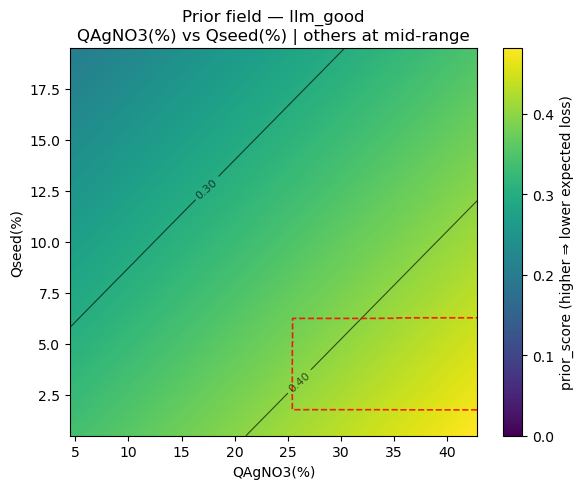

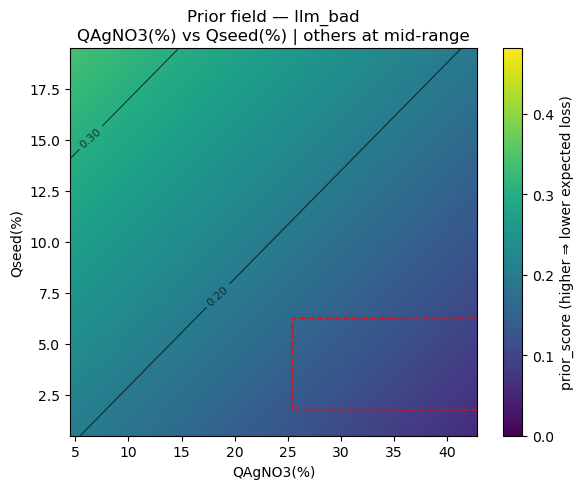

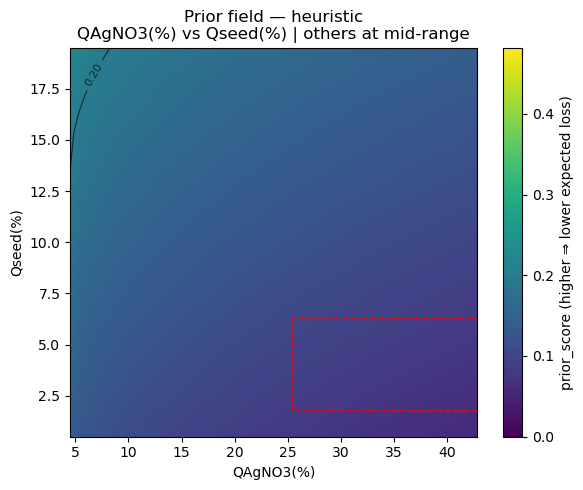

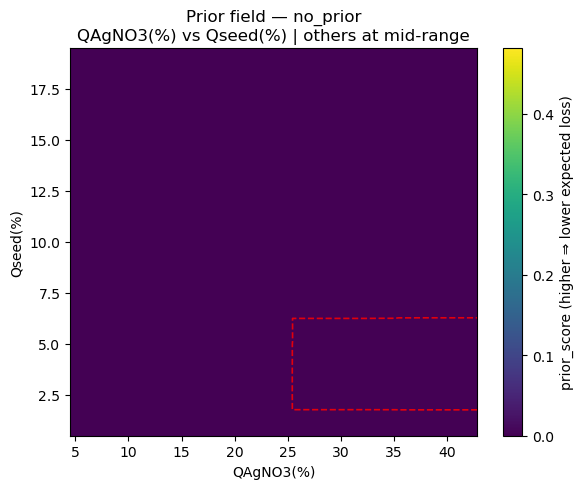

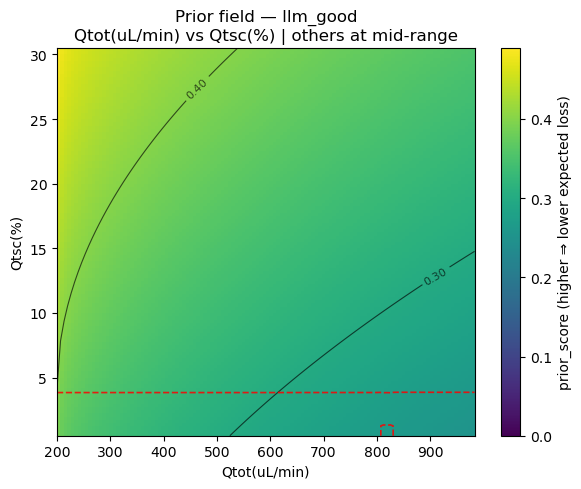

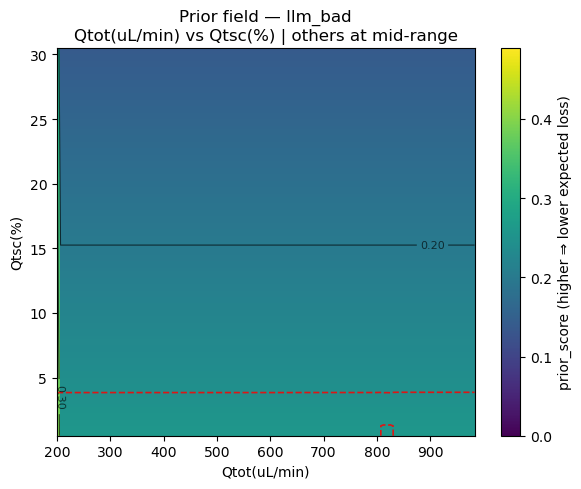

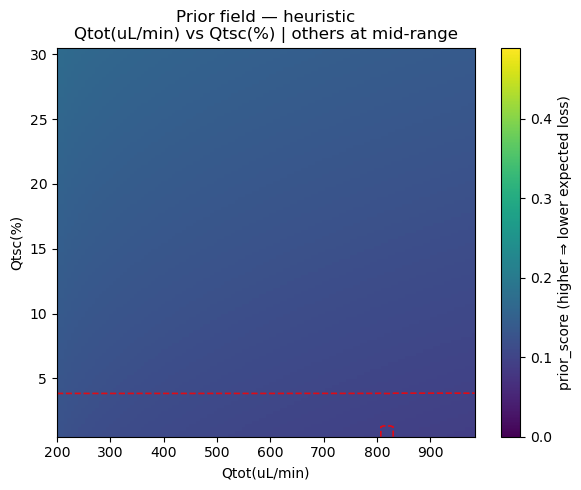

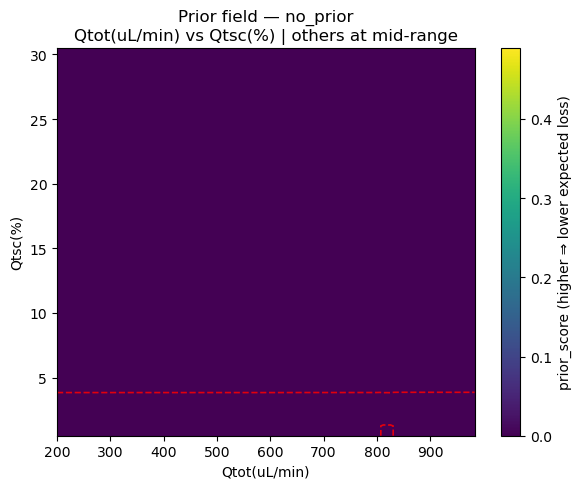

['agnp_prior_fields\\delta_field_llm_good_minus_llm_bad_QAgNO3pct_vs_Qseedpct.png',
 'agnp_prior_fields\\field_llm_good_QAgNO3pct_vs_Qseedpct.png',
 'agnp_prior_fields\\field_llm_bad_QAgNO3pct_vs_Qseedpct.png']

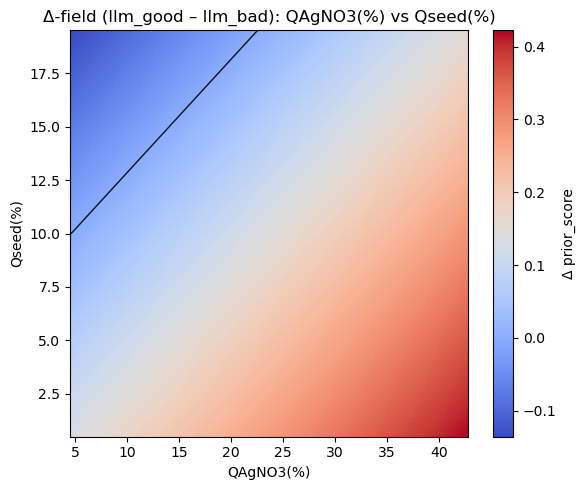

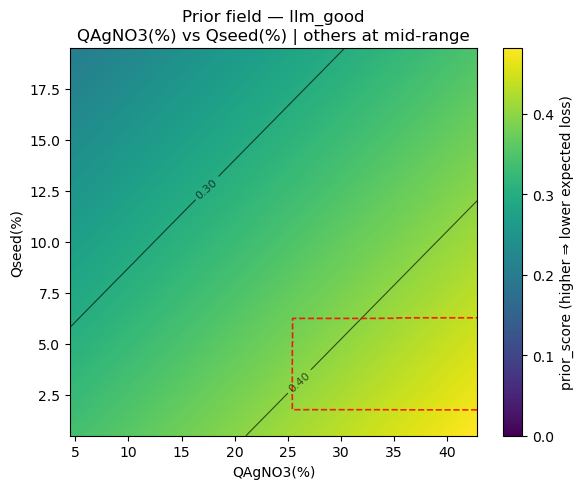

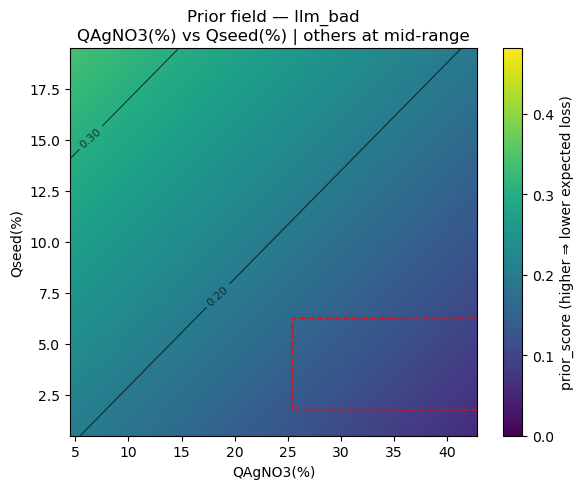

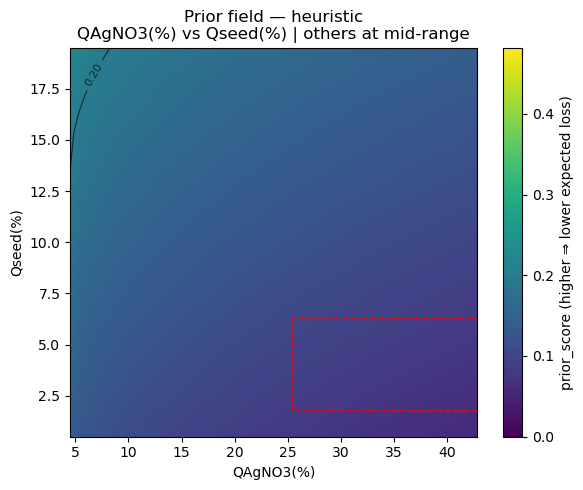

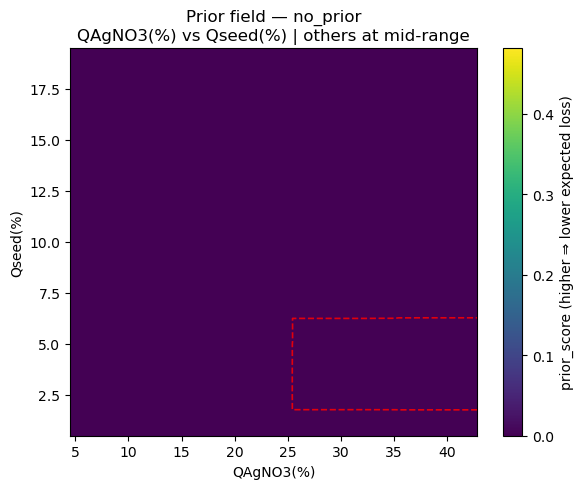

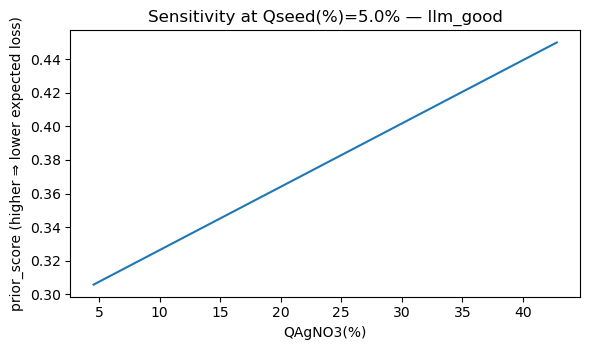

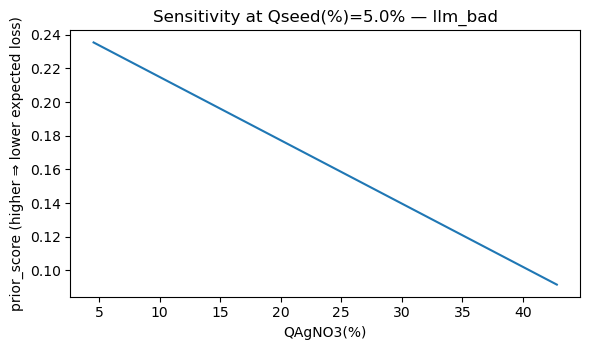

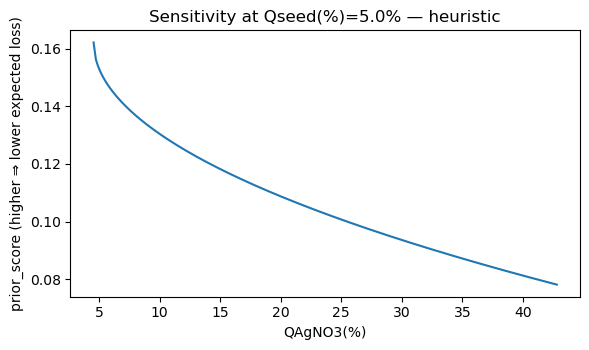

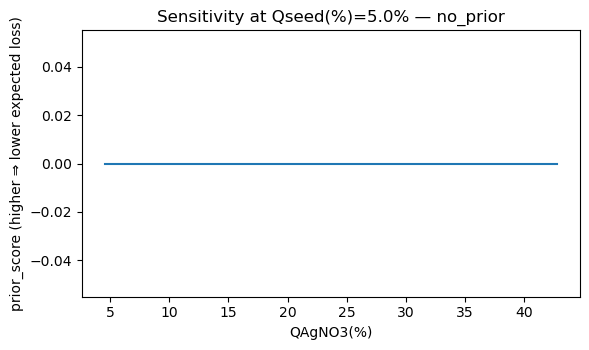

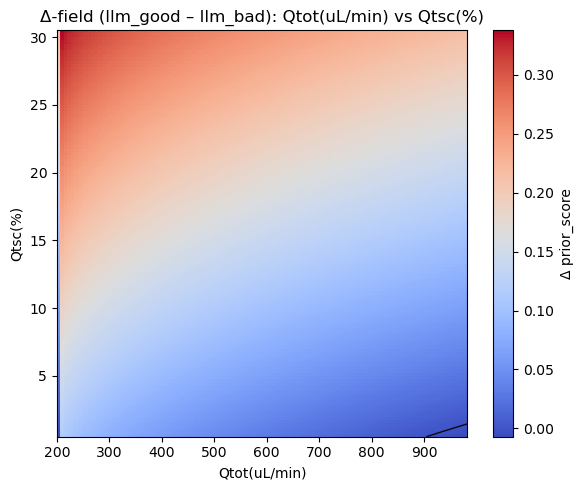

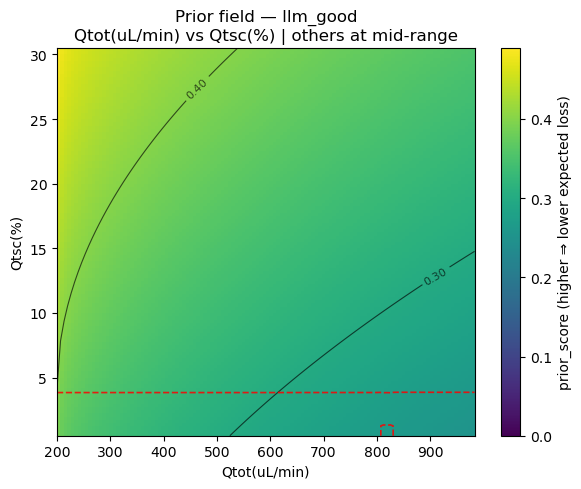

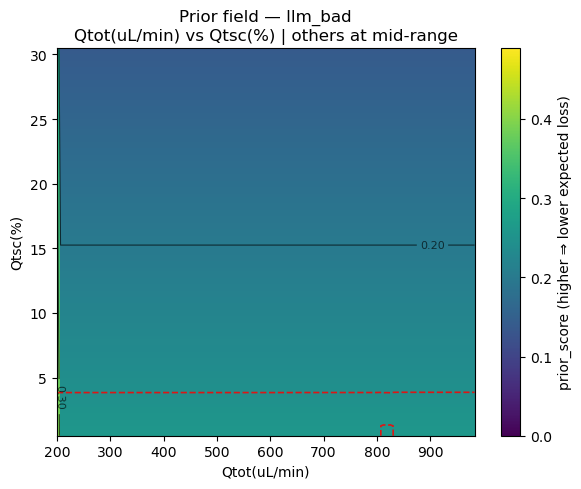

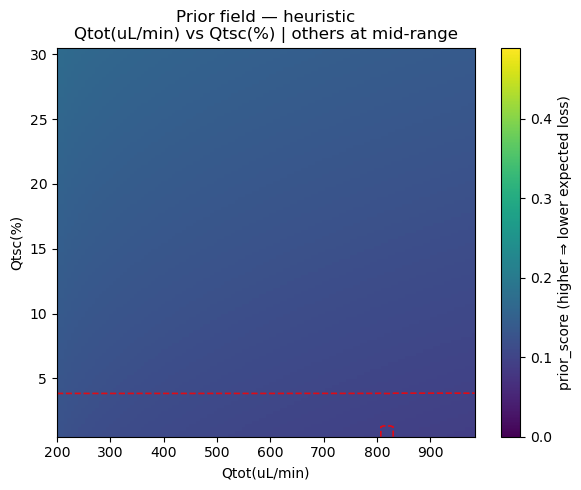

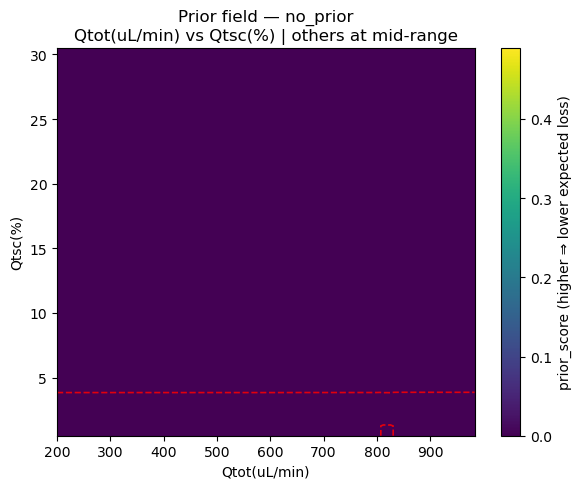

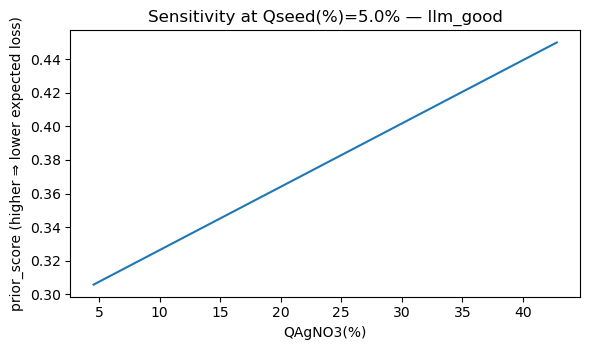

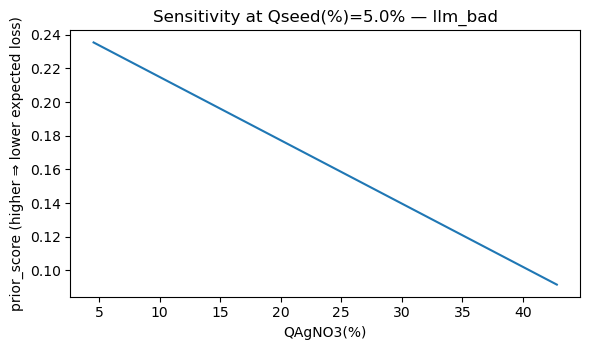

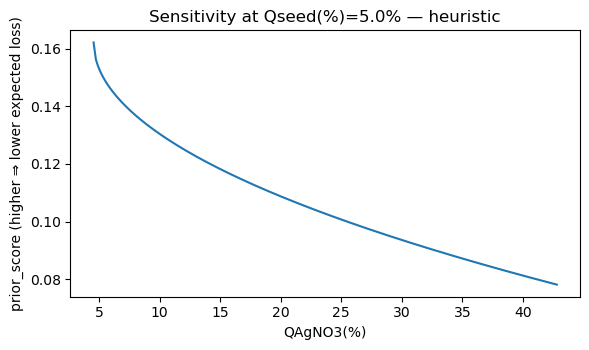

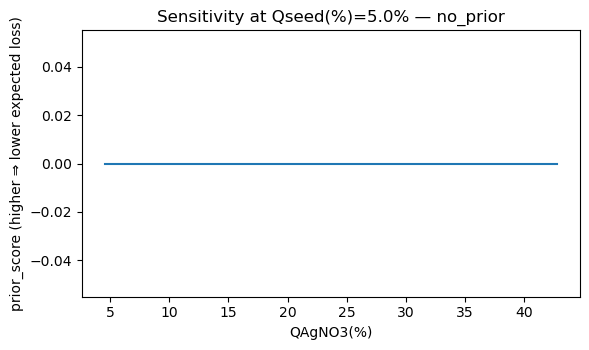

In [22]:
# import importlib, sys
# sys.path.insert(0, "/mnt/data")
# pfm = importlib.import_module("prior_field_maps")
# importlib.reload(pfm)

artifacts = make_prior_field_maps(
    data_csv="AgNP_dataset.csv",
    out_dir="agnp_prior_fields",
    pairs=[("QAgNO3(%)","Qseed(%)"), ("Qtot(uL/min)","Qtsc(%)")],
    priors=("llm_good","llm_bad","heuristic","no_prior"),
    n=120,
    fixed=None,        # or like {"Qpva(%)": 0.75*(max-min)+min}
    show=True,
    return_figs=True
)

artifacts["paths"][:3]  # saved PNG files